# 패키지 다운로드

In [2]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import warnings

from statsmodels.stats.outliers_influence import variance_inflation_factor

np.set_printoptions(suppress=True)


mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

warnings.filterwarnings("ignore")

# 데이터 셋 확인

In [ ]:
# '선박번호', '날짜_시간', '날짜', '시간', '위도', '경도', '대지속력', '실침로', '선수미선','점사이_거리', '시간_차이', '정박지', '평균선회반경(m)', '유속', '유향', '우행', '풍향', '풍속', '최대파고', '유의파고', '평균파고', 'answer', '유행'

In [3]:
# 데이터 불러오기
busan = pd.read_csv("./data/busan_train_full.csv", encoding="cp949")
busan = busan.drop("Unnamed: 0", axis = 1)

## 유향 전처리 다시하기

In [ ]:
# '선박번호', '날짜_시간', '날짜', '시간', '위도', '경도', '대지속력', '실침로', '선수미선', '점사이_거리', '시간_차이', '정박지', '평균선회반경(m)', '유속', '유향', '우행', '풍향', '풍속', '최대파고', '유의파고', '평균파고', 'answer', '유행', 'Combined'

In [4]:
busan_test = busan
busan_test['Combined'] = busan_test['우행'].fillna(busan_test['유행'])
busan_test = busan_test[['선박번호', '날짜_시간', '정박지', '유속', 'Combined', '풍향', '풍속', 'answer']]
busan_test = busan_test.dropna()
busan_test

,선박번호,날짜_시간,정박지,유속,Combined,풍향,풍속,answer
0,1,2021-01-14 22:47:00,3,21.3,98.0,358.0,1.2,0
1,1,2021-01-14 22:50:00,3,21.1,95.0,185.0,0.2,0
2,1,2021-01-14 22:56:00,3,19.6,92.0,284.0,0.1,0
3,1,2021-01-14 23:02:00,3,23.4,100.0,311.0,0.9,0
4,1,2021-01-14 23:11:00,3,20.7,90.0,264.0,1.7,0
...,...,...,...,...,...,...,...,...
251015,247,2022-04-10 17:36:00,3,19.1,71.0,198.0,10.1,0
251016,247,2022-04-10 17:39:00,3,16.9,61.0,196.0,10.6,0
251017,247,2022-04-10 17:45:00,3,18.2,73.0,195.0,9.2,0
251018,247,2022-04-10 17:48:00,3,15.9,73.0,196.0,9.4,0


In [5]:
# 결측치 없는 데이터 정제 / datetime 변환
busan_test_full = busan_test.dropna().reset_index(drop = True)
busan_test_full["날짜_시간"] = pd.to_datetime(busan_test_full["날짜_시간"])

In [6]:
# 보간법
df = pd.DataFrame()
vessle_num = busan_test_full["선박번호"].unique()

for i in vessle_num:
    temp = busan_test_full[busan_test_full["선박번호"] == i]

    temp = temp.set_index('날짜_시간')
    temp = temp.resample('1T').mean().interpolate()
    df = pd.concat([df, temp], axis = 0)
    
# 보간법으로 늘어난 answer의 값을 0, 1로 조정
df.loc[df['answer'] != 1, 'answer'] = 0
df= df.reset_index()
df

,날짜_시간,선박번호,정박지,유속,Combined,풍향,풍속,answer
0,2021-01-14 22:47:00,1.0,3.0,21.300000,98.000000,358.000000,1.200000,0.0
1,2021-01-14 22:48:00,1.0,3.0,21.233333,97.000000,300.333333,0.866667,0.0
2,2021-01-14 22:49:00,1.0,3.0,21.166667,96.000000,242.666667,0.533333,0.0
3,2021-01-14 22:50:00,1.0,3.0,21.100000,95.000000,185.000000,0.200000,0.0
4,2021-01-14 22:51:00,1.0,3.0,20.850000,94.500000,201.500000,0.183333,0.0
...,...,...,...,...,...,...,...,...
338735,2022-04-10 17:47:00,247.0,3.0,16.666667,73.000000,195.666667,9.333333,0.0
338736,2022-04-10 17:48:00,247.0,3.0,15.900000,73.000000,196.000000,9.400000,0.0
338737,2022-04-10 17:49:00,247.0,3.0,17.100000,74.666667,197.000000,9.033333,0.0
338738,2022-04-10 17:50:00,247.0,3.0,18.300000,76.333333,198.000000,8.666667,0.0


In [67]:
# 상관관계 돌려보기 (연속형 변수끼리만)
busan_1 = busan_test_full[['대지속력', '실침로', '선수미선', '유속', 'Combined', '풍향', '풍속']]
busan_corr = busan_1.corr()
busan_corr

,대지속력,실침로,선수미선,유속,Combined,풍향,풍속
대지속력,1.000000,-0.004360,-0.030474,-0.001514,-0.007437,-0.015800,0.274774
실침로,-0.004360,1.000000,0.014183,-0.004762,-0.023509,-0.076499,0.023524
선수미선,-0.030474,0.014183,1.000000,0.076865,-0.167962,0.436558,0.080317
유속,-0.001514,-0.004762,0.076865,1.000000,-0.202303,-0.048594,-0.033474
Combined,-0.007437,-0.023509,-0.167962,-0.202303,1.000000,-0.025460,0.001356
풍향,-0.015800,-0.076499,0.436558,-0.048594,-0.025460,1.000000,-0.029534
풍속,0.274774,0.023524,0.080317,-0.033474,0.001356,-0.029534,1.000000


In [78]:
# 상관관계 돌려보기 (명목형 변수 더미처리)
dummy = pd.get_dummies(busan_test_full['정박지'], drop_first = True)

dummy_busan = pd.concat([dummy, busan_test_full[['대지속력', '실침로', '선수미선', '유속', 'Combined', '풍향', '풍속', 'answer']]], axis = 1)

busan_corr = dummy_busan[[2, 3, 4 ,5,'대지속력', '실침로', '선수미선', '유속', 'Combined', '풍향', '풍속']].corr()
busan_corr

,2,3,4,5,대지속력,실침로,선수미선,유속,Combined,풍향,풍속
2,1.000000,-0.457959,-0.177564,-0.112581,-0.040327,-0.074302,-0.046465,0.000710,0.003729,0.162782,-0.238368
3,-0.457959,1.000000,-0.287971,-0.182582,-0.117405,-0.025779,0.188710,-0.052872,0.004254,0.057786,0.104673
4,-0.177564,-0.287971,1.000000,-0.070792,0.165697,0.059880,0.154574,-0.020470,-0.050184,0.115817,0.058899
5,-0.112581,-0.182582,-0.070792,1.000000,-0.019072,0.011894,0.016677,-0.029661,0.052937,0.069570,-0.055617
대지속력,-0.040327,-0.117405,0.165697,-0.019072,1.000000,-0.004360,-0.030474,-0.001514,-0.007437,-0.015800,0.274774
실침로,-0.074302,-0.025779,0.059880,0.011894,-0.004360,1.000000,0.014183,-0.004762,-0.023509,-0.076499,0.023524
선수미선,-0.046465,0.188710,0.154574,0.016677,-0.030474,0.014183,1.000000,0.076865,-0.167962,0.436558,0.080317
유속,0.000710,-0.052872,-0.020470,-0.029661,-0.001514,-0.004762,0.076865,1.000000,-0.202303,-0.048594,-0.033474
Combined,0.003729,0.004254,-0.050184,0.052937,-0.007437,-0.023509,-0.167962,-0.202303,1.000000,-0.025460,0.001356
풍향,0.162782,0.057786,0.115817,0.069570,-0.015800,-0.076499,0.436558,-0.048594,-0.025460,1.000000,-0.029534


In [68]:
# VIF 계산
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(
    busan_1.values, i) for i in range(busan_1.shape[1])]
vif["features"] = busan_2.columns
vif

,VIF Factor,features
0,1.404051,대지속력
1,3.297483,실침로
2,3.891299,선수미선
3,2.725069,유속
4,3.015036,유향
5,3.535820,풍향
6,3.612072,풍속


In [71]:
# VIF 계산 - 더미데이터 포함
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(
    dummy_busan.values, i) for i in range(dummy_busan.shape[1])]
vif["features"] = dummy_busan.columns
vif

,VIF Factor,features
0,2.084301,2
1,3.107311,3
2,1.618230,4
3,1.237519,5
4,1.455767,대지속력
5,3.383353,실침로
6,4.288394,선수미선
7,2.786524,유속
8,3.285635,Combined
9,4.105190,풍향


### 보간 & 더미 데이터

In [7]:
dummy = pd.get_dummies(df['정박지'], drop_first = True)

dummy_busan = pd.concat([dummy, df[['선박번호', '유속', 'Combined', '풍향', '풍속', 'answer']]], axis = 1)

### 학습데이터 준비

In [8]:
busan_df = dummy_busan[['선박번호', "유속","Combined","풍향","풍속",2,3,4,5,"answer"]]
busan_df

,선박번호,유속,Combined,풍향,풍속,2.0,3.0,4.0,5.0,answer
0,1.0,21.300000,98.000000,358.000000,1.200000,0,1,0,0,0.0
1,1.0,21.233333,97.000000,300.333333,0.866667,0,1,0,0,0.0
2,1.0,21.166667,96.000000,242.666667,0.533333,0,1,0,0,0.0
3,1.0,21.100000,95.000000,185.000000,0.200000,0,1,0,0,0.0
4,1.0,20.850000,94.500000,201.500000,0.183333,0,1,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...
338735,247.0,16.666667,73.000000,195.666667,9.333333,0,1,0,0,0.0
338736,247.0,15.900000,73.000000,196.000000,9.400000,0,1,0,0,0.0
338737,247.0,17.100000,74.666667,197.000000,9.033333,0,1,0,0,0.0
338738,247.0,18.300000,76.333333,198.000000,8.666667,0,1,0,0,0.0


## 유향 전처리 안한 데이터
- 위에서 유향 데이터 전처리 이후 진행 안함

In [118]:
# 결측치 없는 데이터 정제
busan_full = busan.dropna().reset_index(drop = True)
busan_full

,선박번호,날짜_시간,날짜,시간,위도,경도,대지속력,실침로,선수미선,점사이_거리,...,유향,우행,풍향,풍속,최대파고,유의파고,평균파고,answer,유행,Combined


### 명목 - 연속 상관관계 분석을 위한 더미데이터 생성

In [38]:
dummy_busan = pd.get_dummies(busan_full['정박지'], drop_first=True)
pd.concat([dummy_busan, busan_full[['대지속력', '실침로', '선수미선', '유속', '유향', '풍향', '풍속']]], axis = 1)

,2,3,4,5,대지속력,실침로,선수미선,유속,유향,풍향,풍속
0,0,0,0,1,0.6,194.8,309.0,13.9,0.0,321.0,4.9
1,0,0,0,1,0.3,193.9,323.0,14.6,0.0,311.0,4.7
2,0,0,0,1,0.6,44.8,333.0,13.5,8.0,311.0,8.0
3,0,0,0,1,0.7,77.8,325.0,17.3,0.0,296.0,7.2
4,0,0,0,1,0.3,213.2,296.0,15.9,0.0,309.0,8.2
...,...,...,...,...,...,...,...,...,...,...,...
223501,0,1,0,0,0.1,125.3,222.0,19.1,8.0,198.0,10.1
223502,0,1,0,0,0.1,149.6,223.0,16.9,8.0,196.0,10.6
223503,0,1,0,0,0.1,152.4,223.0,18.2,8.0,195.0,9.2
223504,0,1,0,0,0.1,172.6,223.0,15.9,8.0,196.0,9.4


In [34]:
# 상관관계 돌려보기
busan_2 = busan_full[['대지속력', '실침로', '선수미선', '유속', '유향', '풍향', '풍속']]
busan_corr = busan_2.corr()
busan_corr

,대지속력,실침로,선수미선,유속,유향,풍향,풍속
대지속력,1.000000,-0.004360,-0.030474,-0.001514,0.016984,-0.015800,0.274774
실침로,-0.004360,1.000000,0.014183,-0.004762,-0.004089,-0.076499,0.023524
선수미선,-0.030474,0.014183,1.000000,0.076865,-0.099973,0.436558,0.080317
유속,-0.001514,-0.004762,0.076865,1.000000,-0.463470,-0.048594,-0.033474
유향,0.016984,-0.004089,-0.099973,-0.463470,1.000000,-0.033367,0.068429
풍향,-0.015800,-0.076499,0.436558,-0.048594,-0.033367,1.000000,-0.029534
풍속,0.274774,0.023524,0.080317,-0.033474,0.068429,-0.029534,1.000000


In [33]:
# VIF 계산
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(
    busan_2.values, i) for i in range(busan_2.shape[1])]
vif["features"] = busan_2.columns
vif

,VIF Factor,features
0,1.404383,대지속력
1,3.242192,실침로
2,3.878666,선수미선
3,2.875087,유속
4,1.903059,유향
5,3.413757,풍향
6,3.639118,풍속


# 데이터 표준화
- 전체 데이터를 표준화

In [9]:
학습길이 = 60
예측기간 = 30
train_test_split = 200000

vessle_num = busan_df["선박번호"].unique()

In [10]:
# 학습데이터
data = []

for j in vessle_num:
    for i in range(0, len(busan_df[busan_df["선박번호"] == j]) 
                   - 학습길이 - 예측기간):
        temp = busan_df[busan_df["선박번호"] == j]

        dataset = temp.values[i:i+학습길이, 1:5]
        data_mean = dataset.mean(axis=0)
        data_std = dataset.std(axis=0)
        dataset = (dataset-data_mean)/data_std

        b = temp.values[i:i+학습길이, 5:]

        dataset = np.column_stack((dataset, b))

        data.append(dataset)
    
data = np.array(data)

print(data.shape)

(318850, 60, 9)


In [11]:
# 정답 데이터
label = []

for j in vessle_num:
    for i in range(0, len(busan_df[busan_df["선박번호"] == j]) 
                   - 학습길이 - 예측기간):
        temp = busan_df[busan_df["선박번호"] == j]

        dataset = temp.values[학습길이 + 예측기간, -1]
        
        label.append(dataset)
        
label = np.array(label)
print(label.shape)

(318850,)


In [26]:
# 학습 - 평가 데이터 분리
data_split = np.split(data, [train_test_split], axis=0)
label_split = np.split(label, [train_test_split], axis=0)

data_train = data_split[0]
data_test = data_split[1]

label_train = label_split[0]
label_test = label_split[1]

# 결과 확인
print(data_train.shape)  # (200000, 60, 9)
print(data_test.shape)  # (118850, 60, 9)

print(label_train.shape)  # (200000,)
print(label_test.shape)  # (118850,)

(200000, 60, 9)
(118850, 60, 9)
(200000,)
(118850,)


# 싱글 스텝 예측
- 과거 히스토리가 주어지면 미래의 값 한 점을 예측

## 하이퍼 파라매터 설정

In [29]:
BATCH_SIZE = 64
# 모델 학습 시 사용할 데이터의 크기
EVALUATION_INTERVAL = 1
# TRAIN_SPLIT / BATCH_SIZE
EPOCHS = 10
# 전체 학습 데이터를 학습 반복 단위
tf.random.set_seed(13)

## 학습 및 평가 데이터 추출

In [1]:
# data_train = data_split[0]
# data_test = data_split[1]

# label_train = label_split[0]
# label_test = label_split[1]

BUFFER_SIZE = 20000
# 모델 학습 시 사용할 데이터의 크기
# 데이터셋 크기의 10% ~ 20%

train_data = tf.data.Dataset.from_tensor_slices((data_train, label_train))
train_data = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data = tf.data.Dataset.from_tensor_slices((data_test, label_test))
val_data = val_data_multi.batch(BATCH_SIZE).repeat()

NameError: name 'tf' is not defined

## LSTM 모델 구축 및 학습

In [1]:
# 여기부터
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(64, return_sequences=False, input_shape=(60,9)))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(x_train, y_train, 
          batch_size=32, epochs=10, 
          validation_data=(x_eval, y_eval))

# multi_step_history = model.fit(train_data_multi, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL, validation_data=val_data_multi, validation_steps=12)
plot_train_history(multi_step_history,
                   'Multi Step Training and Validation Loss')

NameError: name 'tf' is not defined

## 예측 결과 시각화

In [95]:
x_full_multi, y_full_multi = multivariate_data(dataset, dataset[:, -1], 0, None, past_history, future_target, STEP)

full_data_multi = tf.data.Dataset.from_tensor_slices((x_full_multi, y_full_multi))
full_data_multi = full_data_multi.batch(BATCH_SIZE).repeat(1)

print(x_full_multi.shape)
print(y_full_multi.shape)
print('Single window of past history : {}'.format(x_full_multi[0].shape))
print('Target temperature to predict : {}'.format(y_full_multi[0].shape))

(318, 12, 6)
(318, 6)
Single window of past history : (12, 6)
Target temperature to predict : (6,)


In [96]:
predict = multi_step_model.predict(full_data_multi)

27/27 [==============================] - 1s 3ms/step


In [97]:
temp_list = []

for i in range(len(predict)):
    temp_list.append(predict[i][0])
    if i == (len(predict) - 1):
        for j in predict[i][1:]:
            temp_list.append(j)

In [98]:
temp_df = 원본
MOVING_MEAN = temp_df["PX_LAST"].mean(axis=0)
MOVING_STD = temp_df["PX_LAST"].std(axis=0)

temp_df["PX_LAST_STD"] = (temp_df["PX_LAST"] - MOVING_MEAN) / MOVING_STD
temp_df["PX_LAST_STD_EWM"] = temp_df["PX_LAST_STD"].ewm(span=9, adjust=False).mean()
temp_df

,HSI_value,CCI_value,IPI_value,GDPC_value,Copper price,PX_LAST,PX_LAST_STD,PX_LAST_STD_EWM
Date,,,,,,,,
1995-01-31,1407000,101.13350,71.59,10550.251,1.380976,969917.000,-1.614969,-1.614969
1995-02-28,1316000,100.99640,71.48,10550.251,1.322179,960039.000,-1.642001,-1.620375
1995-03-31,1249000,100.76830,71.60,10550.251,1.351283,1043928.000,-1.412428,-1.578786
1995-04-30,1267000,100.66940,71.49,10581.723,1.328911,1022904.000,-1.469963,-1.557021
1995-05-31,1314000,100.65640,71.82,10581.723,1.260091,979813.000,-1.587887,-1.563194
...,...,...,...,...,...,...,...,...
2022-08-31,1508000,96.33134,104.37,20054.663,3.605426,2124432.105,1.544517,1.520956
2022-09-30,1465000,96.54515,104.57,20054.663,3.452800,2111490.843,1.509102,1.518585
2022-10-31,1426000,96.64653,104.59,20187.495,3.424152,2085632.338,1.438337,1.502535


In [99]:
df_pre = pd.DataFrame(temp_list, index=temp_df.index[12:-1], columns=["Predict"])
df_pre["Predict_EWM"] = df_pre["Predict"].ewm(span=9, adjust=False).mean()
df_pre

,Predict,Predict_EWM
Date,,
1996-01-31,-1.473963,-1.473963
1996-02-29,-1.472914,-1.473753
1996-03-31,-1.466816,-1.472366
1996-04-30,-1.461457,-1.470184
1996-05-31,-1.449593,-1.466066
...,...,...
2022-07-31,1.660974,1.522547
2022-08-31,1.357337,1.489505
2022-09-30,1.551247,1.501853


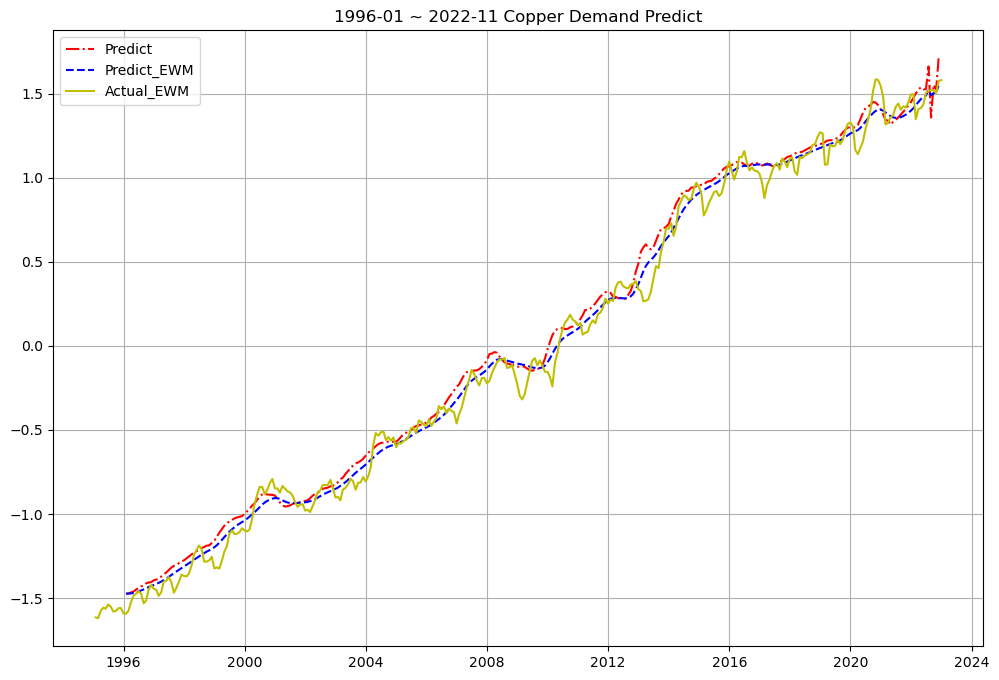

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,8))
plt.plot(df_pre["Predict"], 'r-.')
plt.plot(df_pre["Predict_EWM"], 'b--')
plt.plot(total["PX_LAST_STD_EWM"],'y')

plt.title("1996-01 ~ 2022-11 Copper Demand Predict")

plt.legend(["Predict", "Predict_EWM", "Actual_EWM"])

plt.grid()
plt.show()

# 뭔가 해보기

In [102]:
temp_df = 원본
MOVING_MEAN = temp_df["PX_LAST"].mean(axis=0)
MOVING_STD = temp_df["PX_LAST"].std(axis=0)
temp_df["PX_LAST_STD"] = (temp_df["PX_LAST"] - MOVING_MEAN) / MOVING_STD
temp_df["PX_LAST_STD_EWM"] = temp_df["PX_LAST_STD"].ewm(span=9, adjust=False).mean()

In [103]:
x_full_multi, y_full_multi = multivariate_data(dataset, dataset[:, -1], 0, None, past_history, future_target, STEP)

In [104]:
# (1995.01 - 1995.12) ~ (2021.6 - 2022.5)
x_full_multi.shape

(318, 12, 6)

In [105]:
temp_list = []

temp_list.append(dataset[318:330])
temp_list.append(dataset[319:331])
temp_list.append(dataset[320:332])
temp_list.append(dataset[321:333])
temp_list.append(dataset[322:334])
temp_list.append(dataset[323:335])
temp_list.append(dataset[324:336])

temp_array = np.array(temp_list)
temp_array.shape

(7, 12, 6)

In [106]:
x_full_multi = np.append(x_full_multi, temp_array, axis = 0)

In [107]:
full_data_multi = tf.data.Dataset.from_tensor_slices(x_full_multi)
full_data_multi = full_data_multi.batch(BATCH_SIZE).repeat(1)

In [108]:
predict = multi_step_model.predict(full_data_multi)

28/28 [==============================] - 1s 3ms/step


In [109]:
temp_list = []

for i in range(len(predict)):
    temp_list.append(predict[i][0])
    if i == (len(predict) - 1):
        for j in predict[i][1:]:
            temp_list.append(j)
            
len(temp_list)

330

In [110]:
temp_index = pd.date_range(start='1996-01-01', end='2023-07-01', freq='M')

df_pre = pd.DataFrame(temp_list, index=temp_index, columns=["Predict"])
df_pre["Predict_EWM"] = df_pre["Predict"].ewm(span=9, adjust=False).mean()

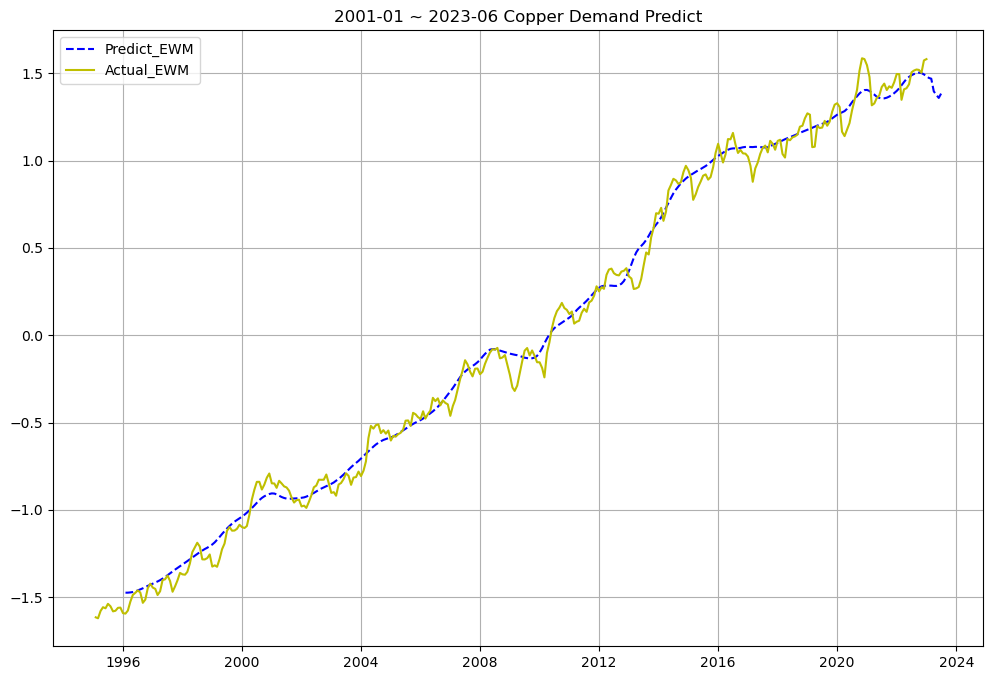

In [111]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,8))
plt.plot(df_pre["Predict_EWM"], 'b--')
plt.plot(temp_df["PX_LAST_STD_EWM"],'y')
# plt.plot(total["PX_LAST_STD_EWM"],'y')

plt.title("2001-01 ~ 2023-06 Copper Demand Predict")
# plt.title("1996-01-01 ~ 2023-06 Copper Demand Predict")

plt.legend(["Predict_EWM", "Actual_EWM"])
plt.grid()
plt.show()

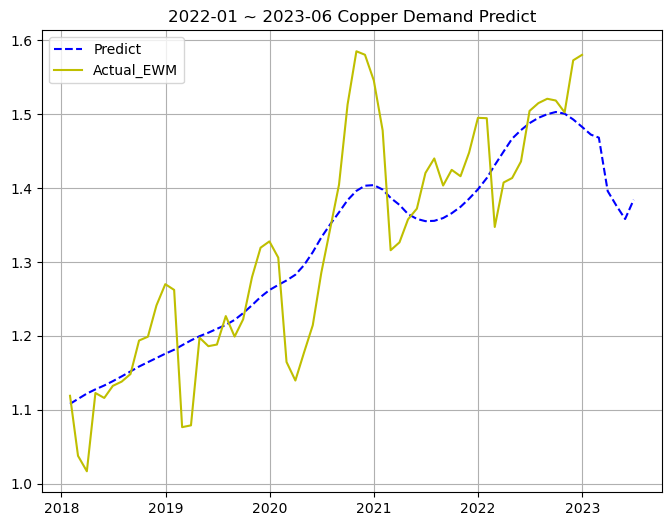

In [112]:
plt.plot(df_pre["Predict_EWM"][-66:], 'b--')
plt.plot(total["PX_LAST_STD_EWM"][-60:],'y')

plt.title("2022-01 ~ 2023-06 Copper Demand Predict")

plt.legend(["Predict", "Actual_EWM"])

plt.grid()
plt.show()

# 모델 저장

In [113]:
from keras.models import load_model

multi_step_model.save('0329_1059_Demand.h5')

# df_pre.to_csv("./수요공급 합치기/구리 수요 예측.csv")

# 모델 불러오기

In [19]:
from keras.models import load_model

multi_step_model = load_model('0329_1059_Demand.h5')

# 뭔가 또 해보기

In [59]:
dataset = test.values
data_mean = dataset.mean(axis=0)
data_std = dataset.std(axis=0)
dataset = (dataset-data_mean)/data_std

print(dataset.shape)

(276, 6)


In [60]:
past_history = 12
future_target = 6
STEP = 1

x_test_multi, y_test_multi = multivariate_data(dataset, dataset[:, -1], 0, None, past_history, future_target, STEP)

In [61]:
# (2000.01 - 2000.12) ~ (2021.6 - 2022.5)
x_test_multi.shape

(258, 12, 6)

In [62]:
dataset.shape

(276, 6)

In [63]:
temp_list = []

temp_list.append(dataset[258:270])
temp_list.append(dataset[259:271])
temp_list.append(dataset[260:272])
temp_list.append(dataset[261:273])
temp_list.append(dataset[262:274])
temp_list.append(dataset[263:275])
temp_list.append(dataset[264:276])

temp_array = np.array(temp_list)
temp_array.shape

(7, 12, 6)

In [64]:
x_test_multi = np.append(x_test_multi, temp_array, axis = 0)
x_test_multi.shape

(265, 12, 6)

In [65]:
BATCH_SIZE = 10000

full_test_multi = tf.data.Dataset.from_tensor_slices(x_test_multi)
full_test_multi = full_test_multi.batch(BATCH_SIZE).repeat(1)

In [66]:
predict = multi_step_model.predict(full_test_multi)

1/1 [==============================] - 0s 490ms/step


In [67]:
temp_list = []

for i in range(len(predict)):
    temp_list.append(predict[i][0])
    if i == (len(predict) - 1):
        for j in predict[i][1:]:
            temp_list.append(j)
            
len(temp_list)

270

In [68]:
temp_index = pd.date_range(start='2001-01-01', end='2023-07-01', freq='M')

df_pre = pd.DataFrame(temp_list, index=temp_index, columns=["Predict"])
df_pre["Predict_EWM"] = df_pre["Predict"].ewm(span=9, adjust=False).mean()
df_pre

,Predict,Predict_EWM
2001-01-31,-1.151529,-1.151529
2001-02-28,-1.170883,-1.155400
2001-03-31,-1.190061,-1.162332
2001-04-30,-1.204234,-1.170713
2001-05-31,-1.208240,-1.178218
...,...,...
2023-02-28,1.467317,1.480707
2023-03-31,1.119983,1.408562
2023-04-30,1.338888,1.394627
2023-05-31,1.329255,1.381553


In [12]:
df_pre = pd.read_csv("./수요공급 합치기/구리 수요 예측_최종.csv")
df_pre.index = pd.to_datetime(df_pre["Unnamed: 0"])
df_pre = df_pre.drop("Unnamed: 0", axis = 1)
df_pre

,Predict,Predict_EWM
Unnamed: 0,,
2001-01-31,-1.151529,-1.151529
2001-02-28,-1.170883,-1.155400
2001-03-31,-1.190062,-1.162332
2001-04-30,-1.204234,-1.170713
2001-05-31,-1.208240,-1.178218
...,...,...
2023-02-28,1.467316,1.480707
2023-03-31,1.119983,1.408562
2023-04-30,1.338888,1.394627


In [7]:
MOVING_MEAN = test["PX_LAST"].mean(axis=0)
MOVING_STD = test["PX_LAST"].std(axis=0)

test["PX_LAST_STD"] = (test["PX_LAST"] - MOVING_MEAN) / MOVING_STD
test["PX_LAST_STD_EWM"] = test["PX_LAST_STD"].ewm(span=9, adjust=False).mean()
test

,HSI_value,CCI_value,IPI_value,GDPC_value,Copper price,PX_LAST,PX_LAST_STD,PX_LAST_STD_EWM
Date,,,,,,,,
2000-01-31,1636000,102.83840,91.79,12935.252,0.855289,1149296.000,-1.669927,-1.669927
2000-02-29,1737000,102.89240,92.13,12935.252,0.827855,1177390.000,-1.579402,-1.651822
2000-03-31,1604000,102.80980,92.47,12935.252,0.805130,1279277.000,-1.251102,-1.571678
2000-04-30,1626000,102.79090,93.06,13170.749,0.776305,1342779.000,-1.046485,-1.466639
2000-05-31,1575000,102.76510,93.34,13170.749,0.831318,1319919.000,-1.120145,-1.397341
...,...,...,...,...,...,...,...,...
2022-08-31,1508000,96.33134,104.37,20054.663,3.605426,2124432.105,1.472160,1.444417
2022-09-30,1465000,96.54515,104.57,20054.663,3.452800,2111490.843,1.430460,1.441626
2022-10-31,1426000,96.64653,104.59,20187.495,3.424152,2085632.338,1.347139,1.422728


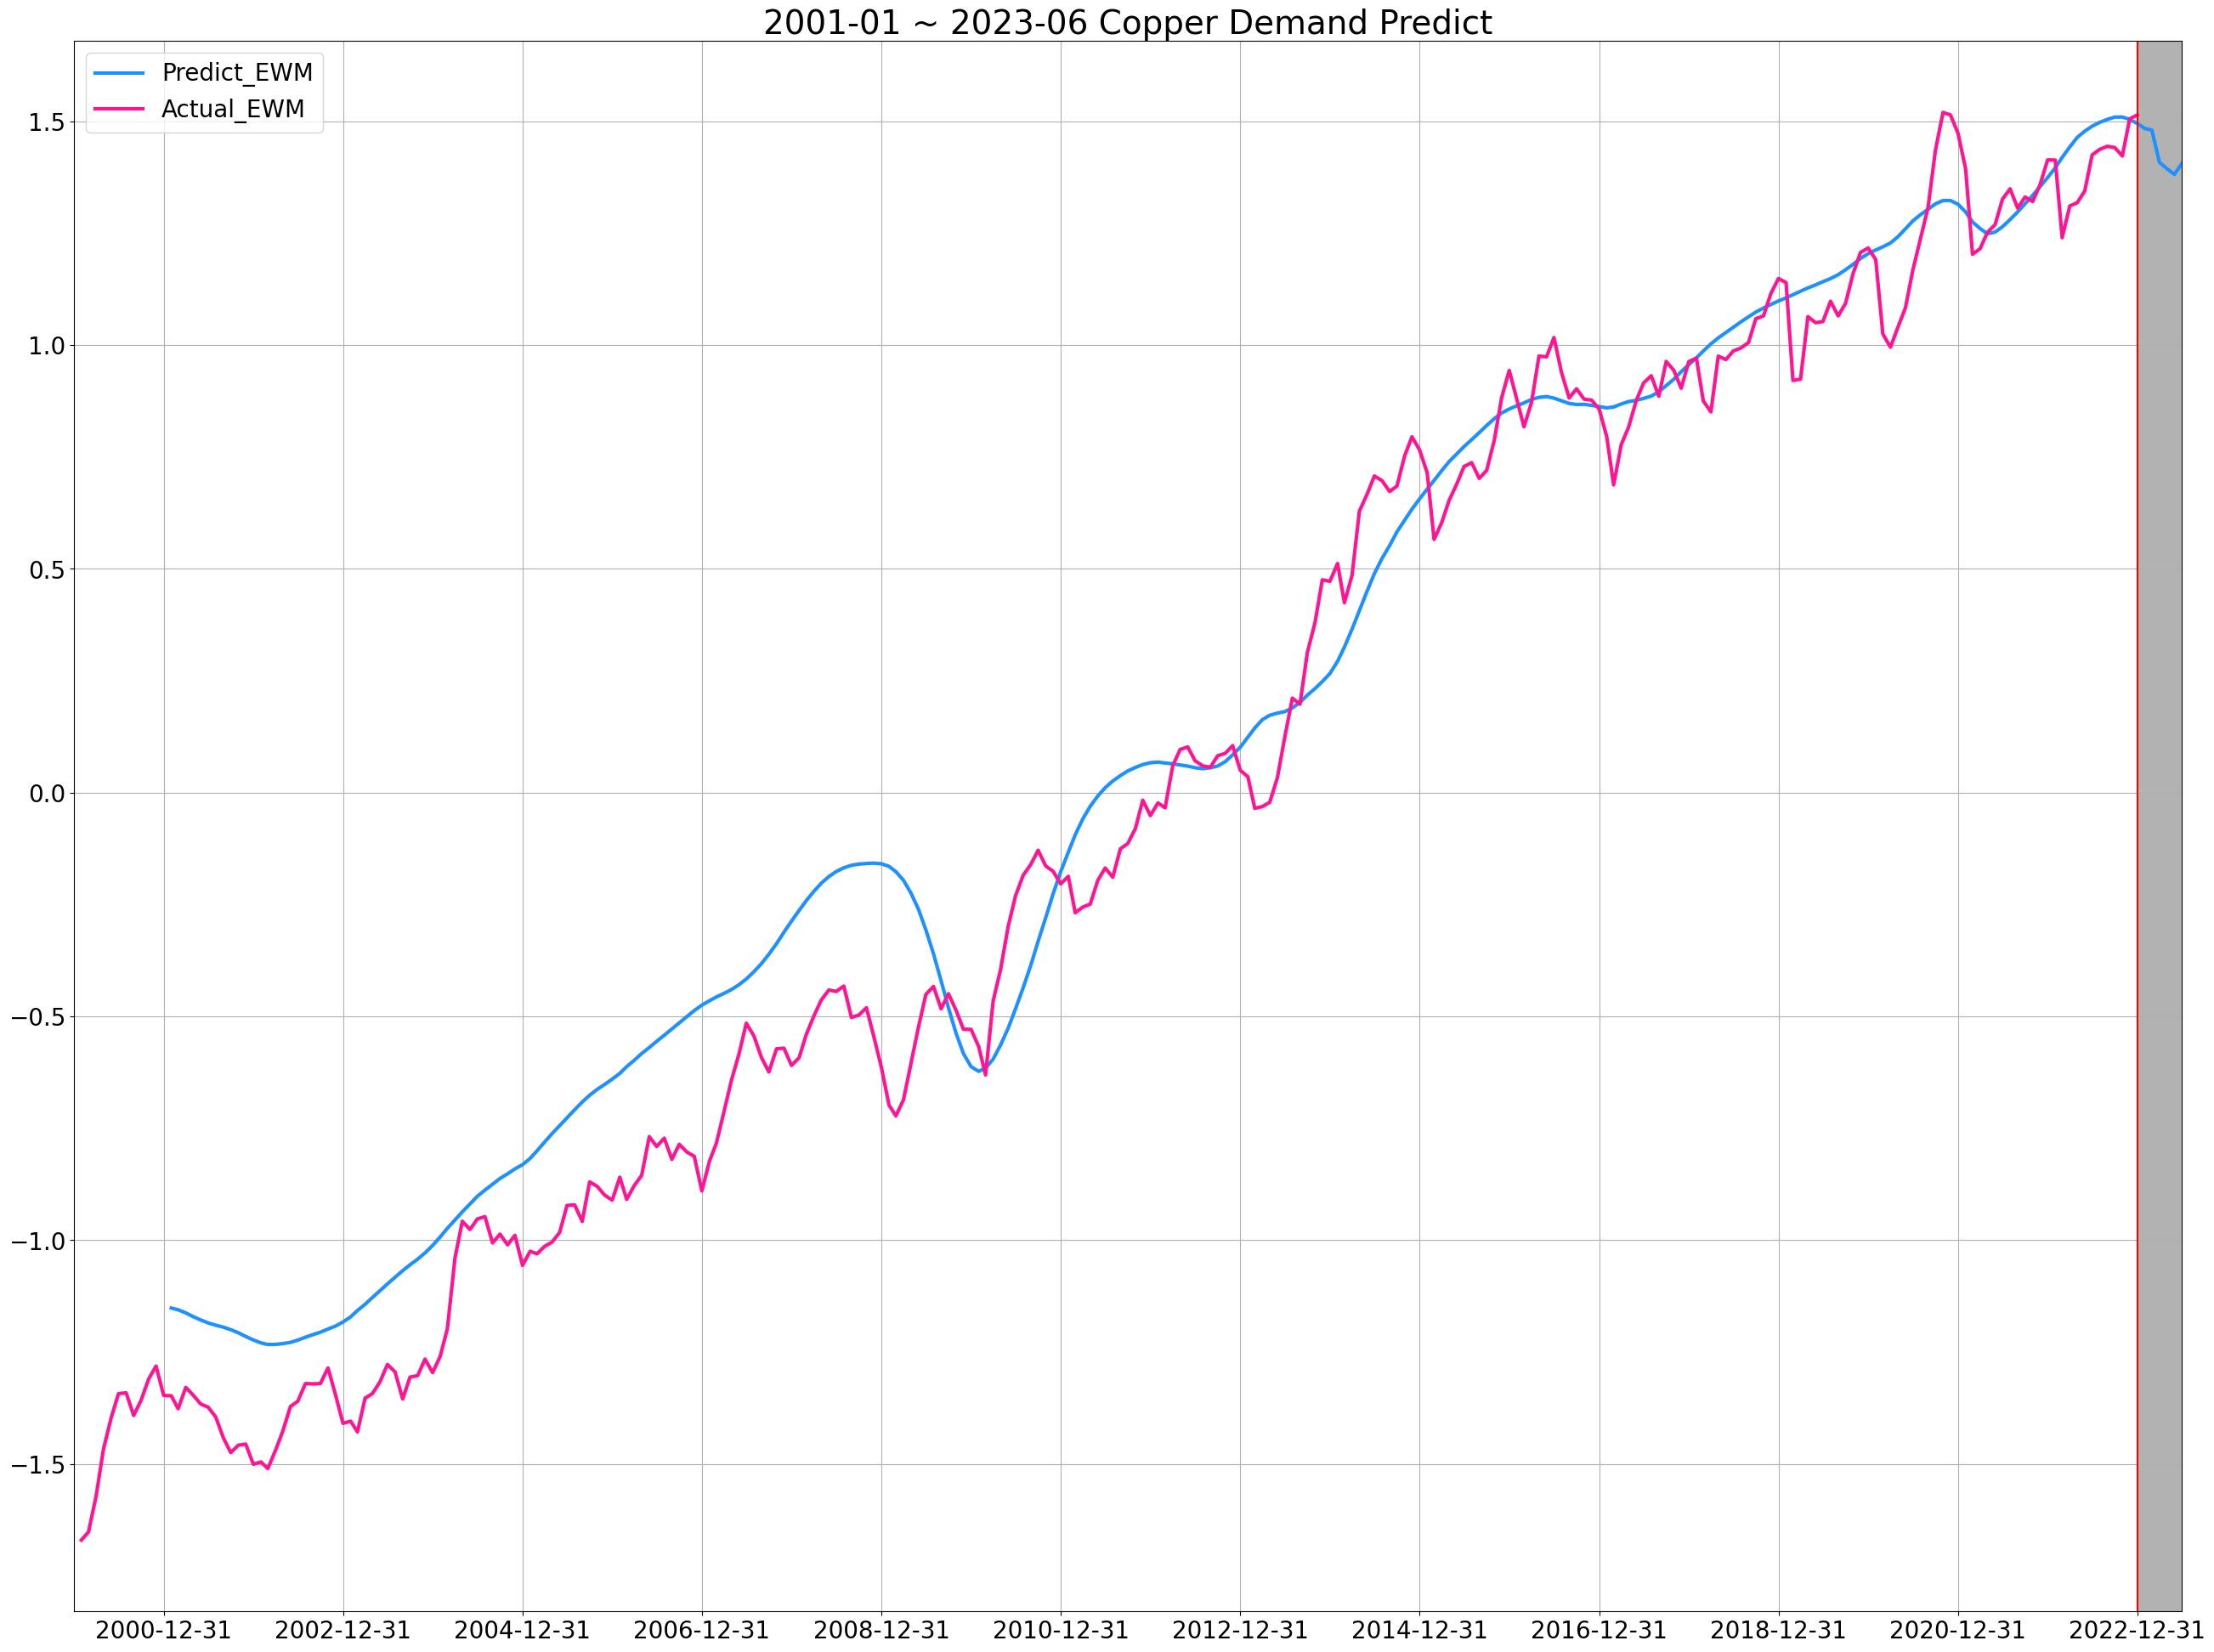

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(32,24))

plt.plot(df_pre["Predict_EWM"], color='dodgerblue', lw='3')
plt.plot(test["PX_LAST_STD_EWM"], color='deeppink', lw='3')

plt.title("2001-01 ~ 2023-06 Copper Demand Predict", size=28)

# plt.legend(["Predict", "Predict_EWM", "Actual_EWM"])
plt.legend(["Predict_EWM", "Actual_EWM"], prop={'size': 20})
plt.xticks(pd.date_range("2000", "2023", freq = "2Y"), size=20)
plt.yticks(size=20)
plt.axvline(pd.to_datetime("2022-12-31"), color='red', lw='1.5')
plt.axvspan(pd.to_datetime("2023-01-01"), pd.to_datetime("2023-06-30"), facecolor='gray', alpha=0.6)
plt.xlim(pd.to_datetime("2000-01-01"), pd.to_datetime("2023-06-30"))

plt.grid()
plt.show()

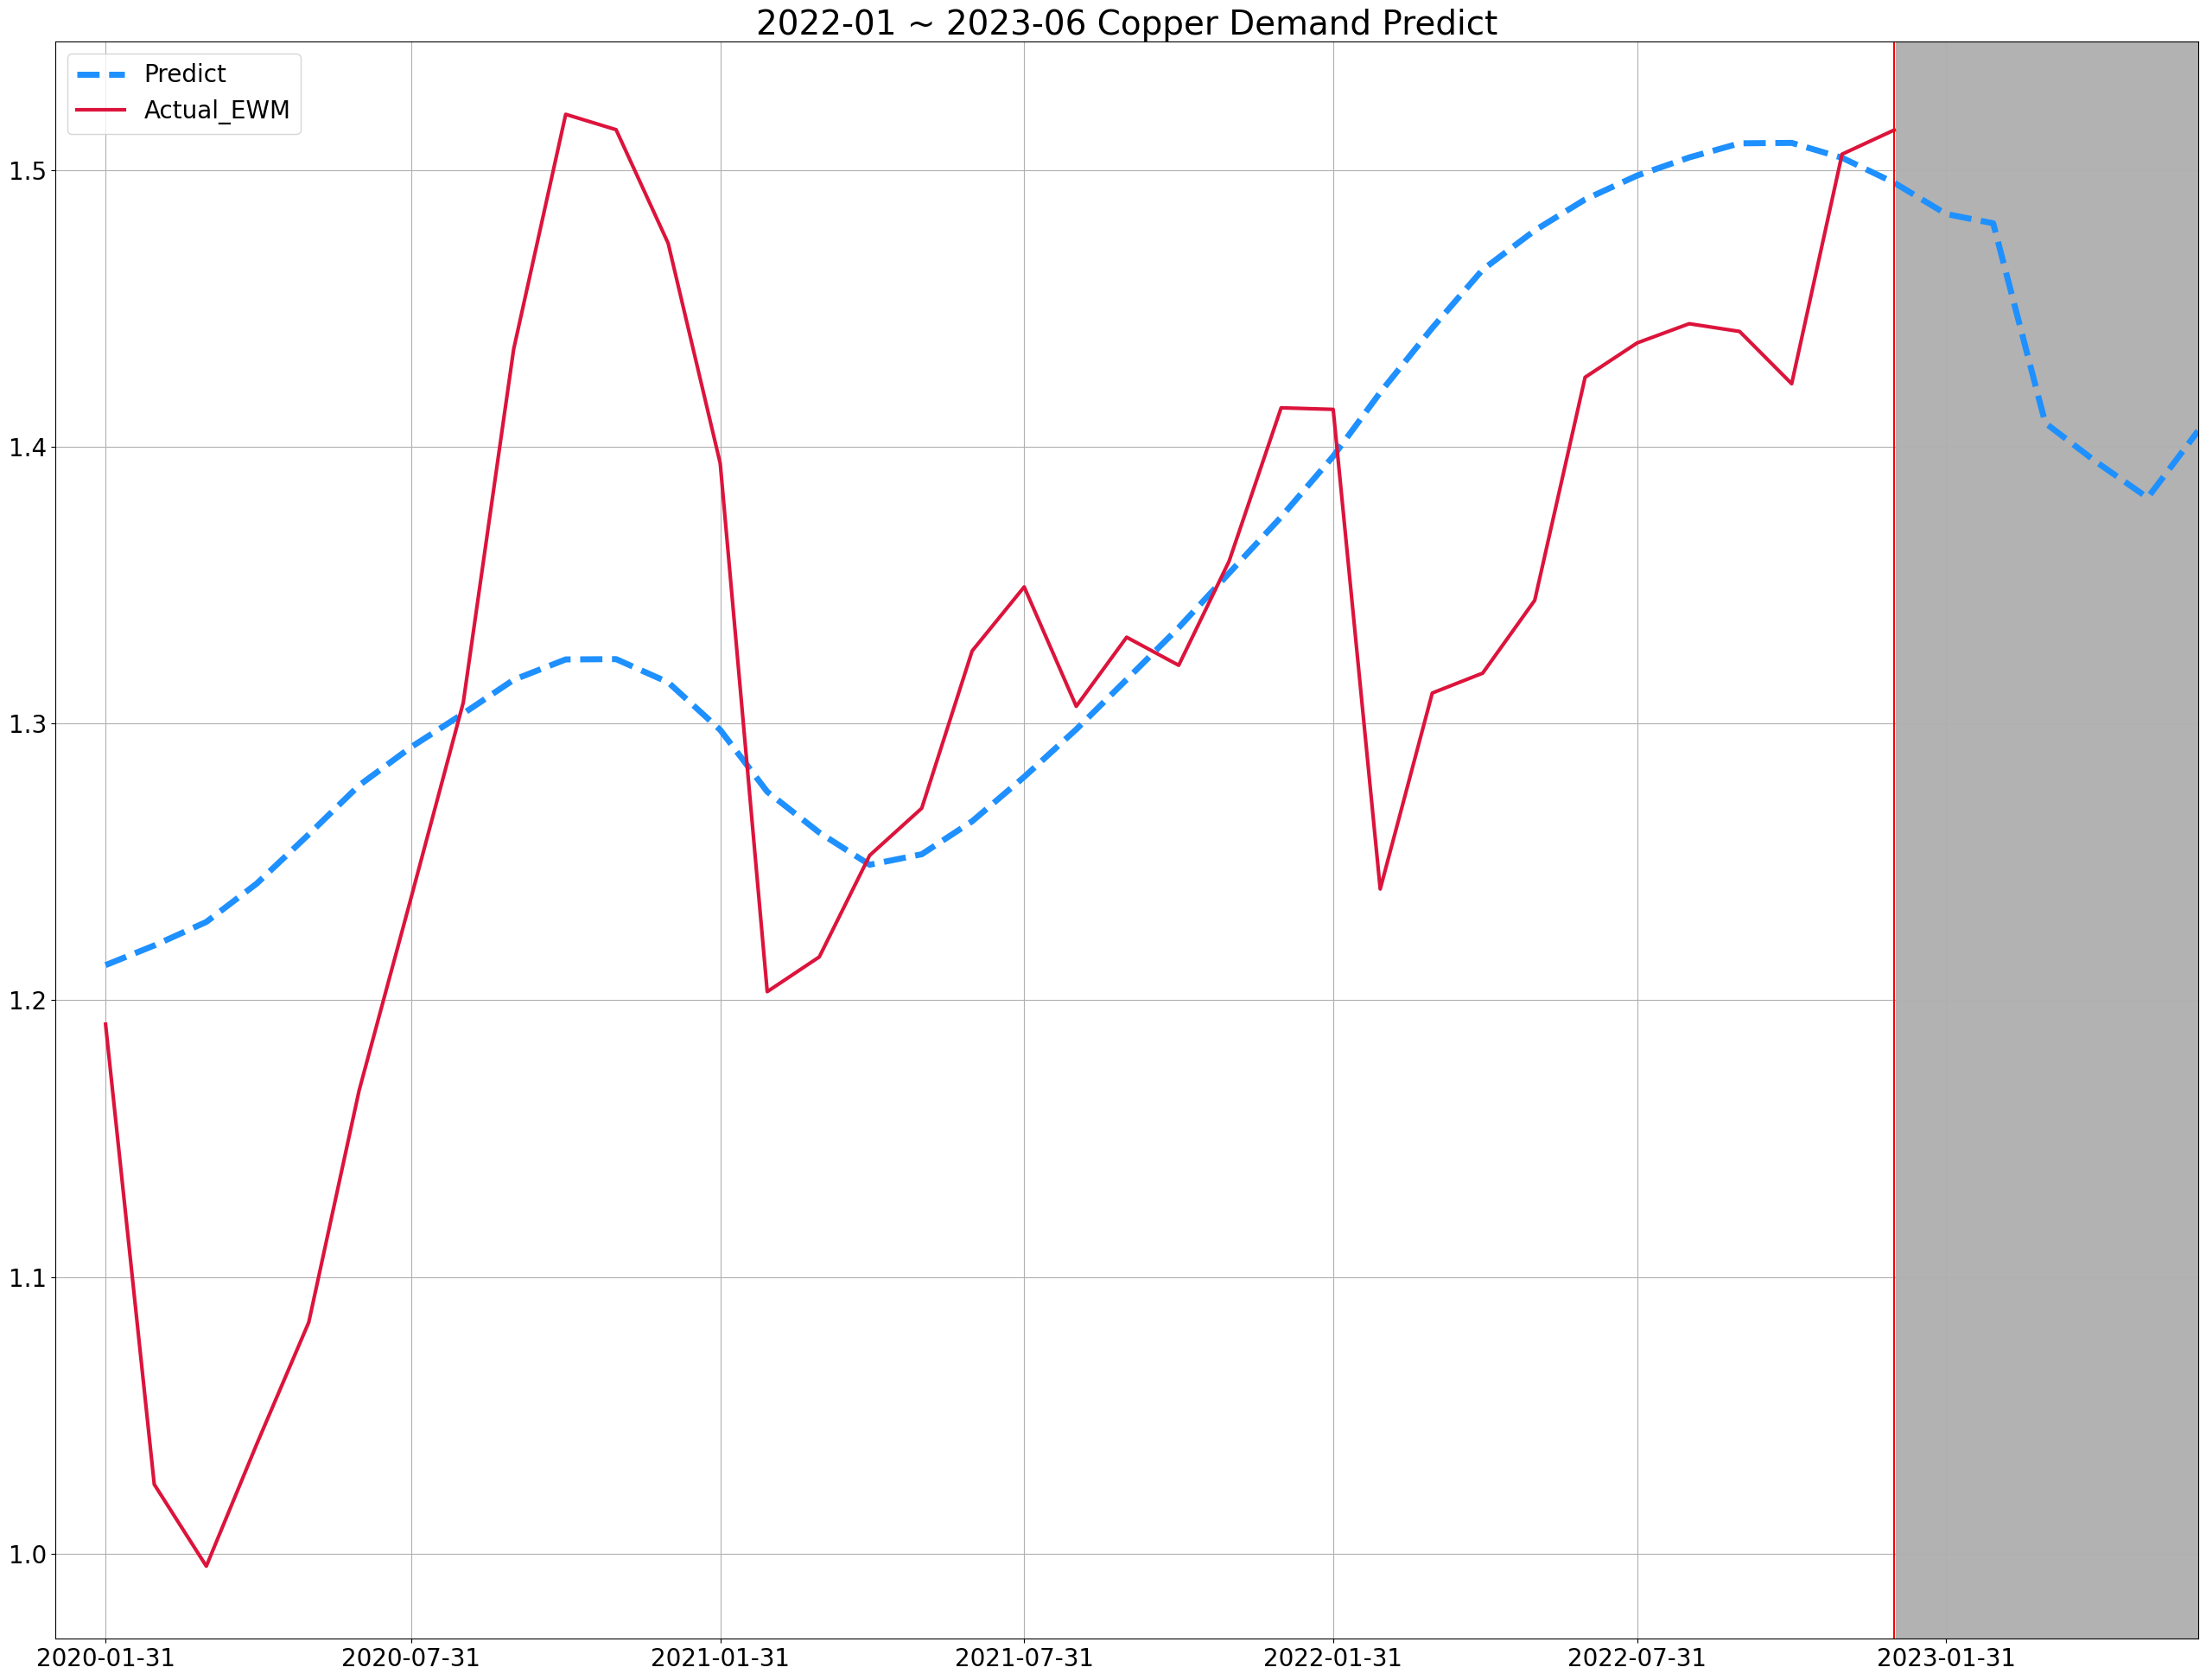

In [28]:
plt.figure(figsize=(32,24))

plt.plot(df_pre["Predict_EWM"][-42:], color='dodgerblue', ls='--', lw='5')
plt.plot(test["PX_LAST_STD_EWM"][-36:], color='crimson', lw='3')

plt.axvspan(pd.to_datetime("2023-01-01"), pd.to_datetime("2023-06-30"), facecolor='gray', alpha=0.6)
plt.axvline(pd.to_datetime("2022-12-31"), color='red', lw='1.5')
plt.xlim(pd.to_datetime("2020-01-01"), pd.to_datetime("2023-06-30"))

plt.xticks(pd.date_range("2020-01-01", "2023-07-01", freq = "6M"), size=20)
plt.yticks(size=20)

plt.title("2022-01 ~ 2023-06 Copper Demand Predict", size=28)
plt.legend(["Predict", "Actual_EWM"], prop={'size': 20})
plt.grid()
plt.show()

# 모델 다시 저장하기

In [31]:
from keras.models import load_model

multi_step_model.save('0329_1145_Demand.h5')

df_pre.to_csv("./수요공급 합치기/구리 수요 예측_최종.csv")

In [58]:
from keras.models import load_model

multi_step_model = load_model('0329_1145_Demand.h5')